# **Data Visualization Notebook**

## Objectives

*   Answer business requirement 1: 
    * The client is interested in conducting a study to visually differentiate a cherry leaf that is healthy from one that contains powdery mildew.


## Inputs

* inputs/cherry-leaves/cherry-leaves/train
* inputs/cherry-leaves/cherry-leaves/test
* inputs/cherry-leaves/cherry-leaves/validation

## Outputs

* Image shape embeddings pickle file.
* Mean and variability of images per label plot.
* Plot to distinguish the contrast between parasite-contained and uninfected cell images.
* Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

## Additional Comments | Insights | Conclusions


* No additional comments.  -- come back to this




---

# Set Data Directory

---

## Import libraries

In [38]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

In [39]:
cwd= os.getcwd()

In [40]:
os.chdir('/workspace/milestone-project-mildew-detection-in-cherry-leaves')
print("Changing directory")

Changing directory


In [41]:
work_dir = os.getcwd()
work_dir

'/workspace/milestone-project-mildew-detection-in-cherry-leaves'

## Set input directories

Set train, validation and test paths.

In [42]:
my_data_dir = 'inputs/cherry-leaves/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [43]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [44]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


---

# Data visualisation of image data

---

## Image shape 

Compute average images size on train set.

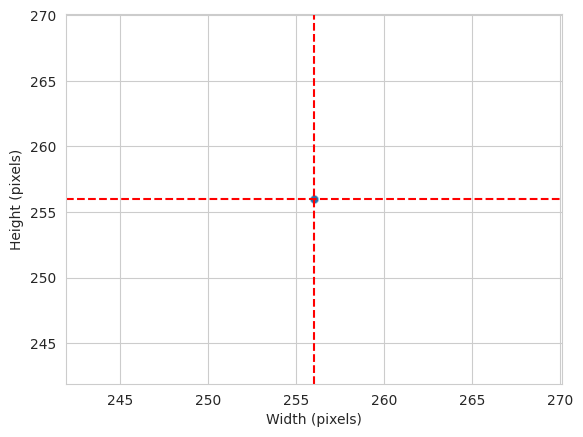

Width average: 256 
Height average: 256


In [45]:
height, width = [], []

for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        h, w, colors = img.shape
        height.append(h)  # image height
        width.append(w)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=width, y=height, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
height_mean = int(np.array(height).mean())
width_mean = int(np.array(width).mean())
axes.axvline(x=height_mean, color='r', linestyle='--')
axes.axhline(y=width_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {width_mean} \nHeight average: {height_mean}")

Images size for training the model is the average from all images in the train set.

In [46]:
image_shape = (height_mean, width_mean, 3)
image_shape

(256, 256, 3)

Recording image dimensions for analysis

In [47]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and variability of images per label

### Function to load images in an array, using tensorflow

In [48]:
from tensorflow.keras.preprocessing import image


def load_image_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y


### Function to load images in an array, using tensorflow

### Load image shapes and labels in an array

In [49]:
X, y = load_image_array(my_data_dir=train_path,
                           new_size=(100,100),
                           n_images_per_label=30)
print(X.shape, y.shape)


(60, 100, 100, 3) (60,)


### Plot and save mean and variability of images per label

In [50]:
def plot_mean_variability_by_label(X, y, figsize=(12, 5), save_image=False):

    for display_label in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == display_label, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {display_label} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {display_label}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {display_label}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{display_label}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")


==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


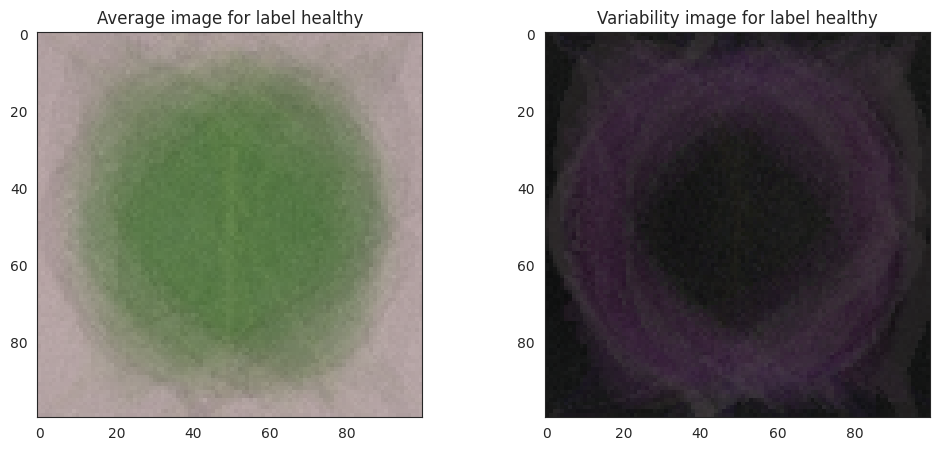

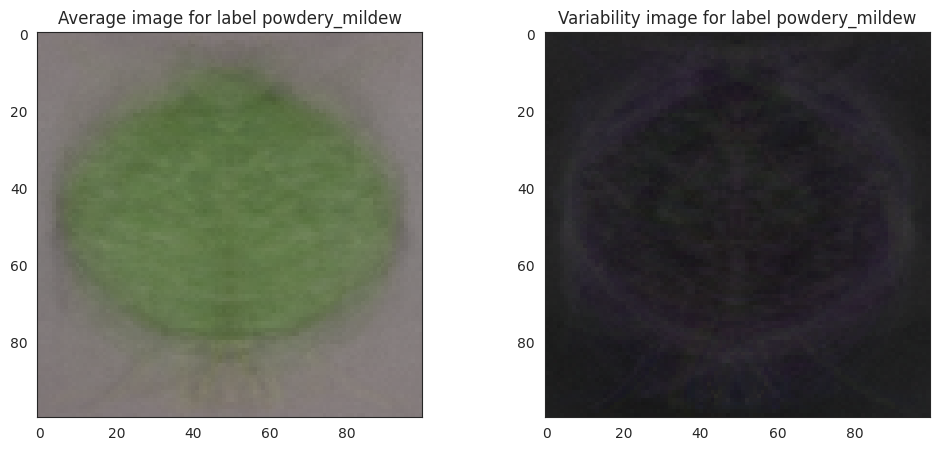

In [51]:
plot_mean_variability_by_label(X=X, y=y, figsize=(12, 5), save_image=True)


---

## Difference between average clean leaf and average infected leaf images

---

In [52]:
def subset_image_label(X, y, display_label):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == display_label, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_images_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


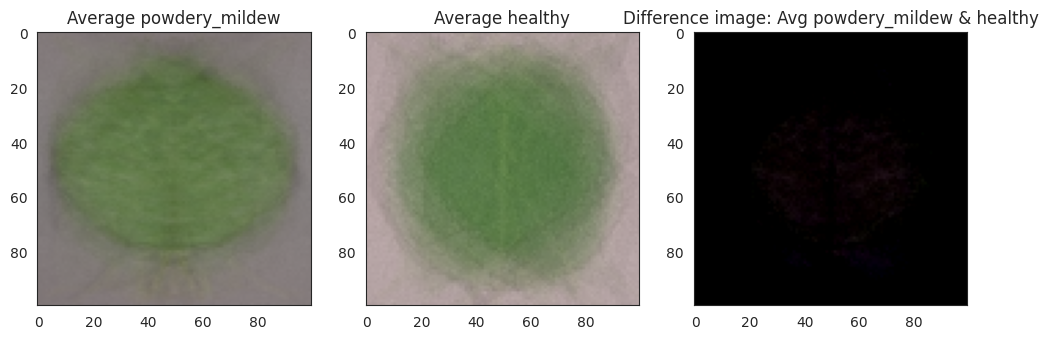

In [53]:
diff_bet_avg_images_as_array(X=X, y=y,
                                        label_1='powdery_mildew', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )


---

## Image Montage

In [54]:
import itertools
import random
sns.set_style("white")


def image_montage(dir_path, display_label, nrows, ncols, figsize=(15, 10)):
    
    labels = os.listdir(dir_path)

    # subset the class you are interested to display
    if display_label in labels:

        # checks if your montage space is greater than the subset size
        images_list = os.listdir(dir_path + '/' + display_label)
        if nrows * ncols < len(images_list):
            img_idx = random.sample(images_list, nrows * ncols)
        else:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {len(images_list)} in your subset. "
                f"You requested a montage with {nrows * ncols} spaces")
            return

        # create a list of axes indices based on nrows and ncols
        list_rows = range(0, nrows)
        list_cols = range(0, ncols)
        plot_idx = list(itertools.product(list_rows, list_cols))

        # create a Figure and display images
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
        for x in range(0, nrows*ncols):
            img = imread(dir_path + '/' + display_label + '/' + img_idx[x])
            img_shape = img.shape
            axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
            axes[plot_idx[x][0], plot_idx[x][1]].set_title(
                f"Width {img_shape[1]}px x Height {img_shape[0]}px")
            axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
            axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
        plt.tight_layout()
        plt.show()

    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


Run Montage in all labels

healthy


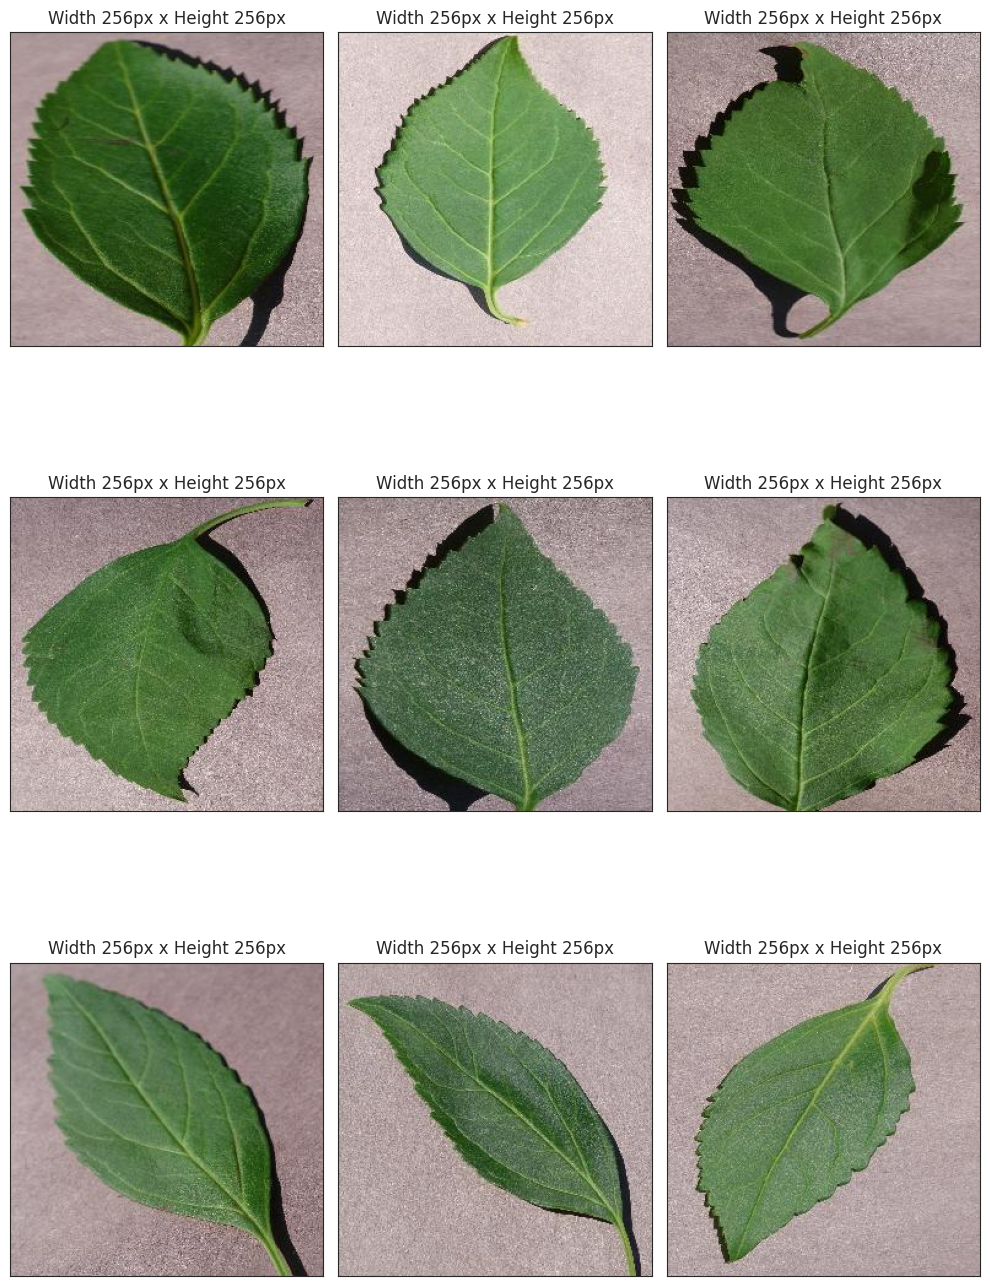



powdery_mildew


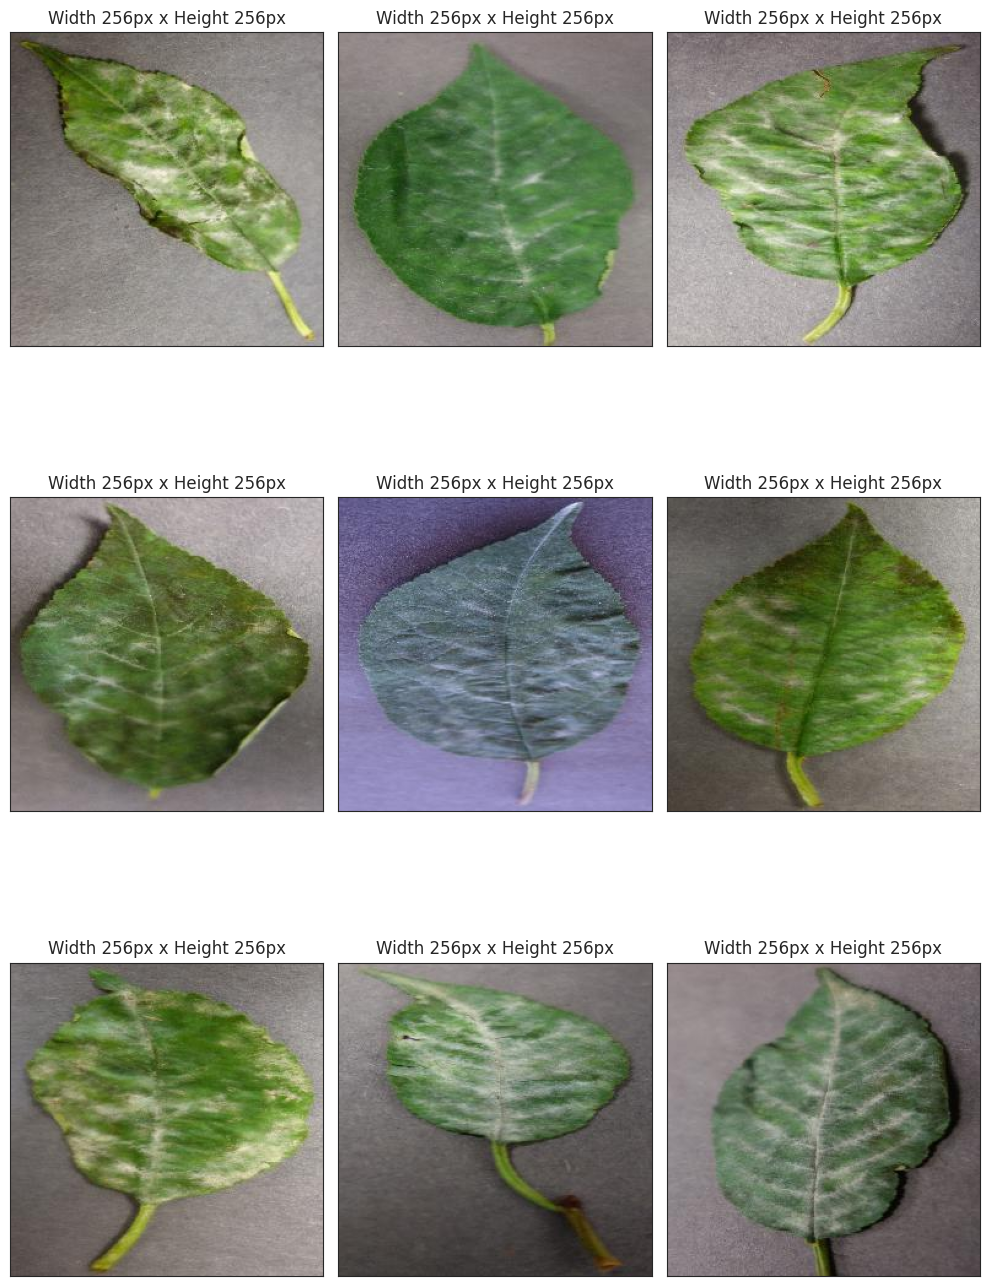

In [55]:
for label in labels:
    print(label)
    image_montage(dir_path=train_path,
                  display_label=label,
                  nrows=3, ncols=3,
                  figsize=(10, 15)
                  )
    print("\n")


# Push files to Repo

## Push generated/new files from this Session to your GitHub repo

* Git add

In [56]:
!git add .

* Git commit

In [57]:
!git commit -am "Added data visualisation notebook"

[main 5c81eaf] Added data visualisation notebook
 4 files changed, 28 insertions(+), 42 deletions(-)


* Git Push

In [58]:
!git push

Enumerating objects: 17, done.
Counting objects: 100% (17/17), done.
Delta compression using up to 32 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (9/9), 3.09 MiB | 7.81 MiB/s, done.
Total 9 (delta 3), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/Swewi/milestone-project-mildew-detection-in-cherry-leaves.git
   f402cf8..5c81eaf  main -> main
